# Fill the $E-L_z$ space

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from astropy import units as u
from galpy.potential import NFWPotential, ChandrasekharDynamicalFrictionForce, evaluatePotentials, FDMDynamicalFrictionForce
from galpy.orbit import Orbit
from matplotlib.colors import ListedColormap, BoundaryNorm
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')
from colossus.halo import concentration
from colossus.halo import profile_nfw

## Parameters

In [2]:
M = 1e9 #mass of the galaxy
redshift = 0 #redshift
m = 6e-22 #mass of the FDM particle in eV
MGC = 1e6
rhm = 0.01 #half mass radius of the satellite in kpc
N = 4500 #number of particles
t0 = 0#initial time
tf = 10 #final time
Nsteps = 2000 #number of steps
seed = 42 #seed for random number generation

### Physical constants

In [3]:
from astropy.constants import G
G = G.to(u.kpc/u.Msun*(u.km/u.s)**2).value
h = 0.704 #hubble constant

## Host halo

In [4]:
c = concentration.concentration(M,'vir',redshift,model ='prada12') #concentration parameter
p_nfw= profile_nfw.NFWProfile(M = M, c = c, z = redshift, mdef = 'vir')

r_vir = p_nfw.RDelta(redshift, 'vir')/h #virial radius 
r_s = p_nfw.par['rs']/h #scale radius

A_NFW = np.log(1 + c) - c/(1+c)
NFWHalo = NFWPotential(amp = M/A_NFW* u.Msun, a = r_s * u.kpc)

In [5]:
print('r_vir:', r_vir, 'kpc')
print('r_s:', r_s, 'kpc')
print('c:', c)

r_vir: 28.851291346060822 kpc
r_s: 1.5727653859255113 kpc
c: 18.344307846614004


## Dynamical Friction

In [6]:
cdf = ChandrasekharDynamicalFrictionForce(GMs=MGC * u.Msun,rhm = rhm * u.kpc, dens=NFWHalo)
fdf= FDMDynamicalFrictionForce(GMs = MGC*u.Msun, rhm = rhm*u.kpc, dens=NFWHalo, m = m*u.eV)

In [7]:
log_m_ratio = np.log10(M/MGC)

## Initial conditions

### Random generation of initial conditions

In [8]:
np.random.seed(seed)
# Compute a random R grid in a logarithmic scale from 0.1*r_s to 10*r_s
R = np.exp(np.random.uniform(np.log(1e-1 * r_s), np.log(10 * r_s), N))
# For each R, compute the escape velocity
POT = evaluatePotentials(NFWHalo, R * u.kpc, 0.)
vEsc = np.sqrt(-2 * POT)
# Compute a random vT for each R, lower that the escape velocity
vR = np.array([np.random.uniform(-v,v) for v in vEsc])
# Compute the radial velocity for each R, with condition v² < vesc² - vT²
vT = np.array([np.random.uniform(-v, v) for v in np.sqrt(vEsc**2 - vR**2)])

In [9]:
Lz_ini = R*vT
Lz_ini_norm = Lz_ini/np.max(np.abs(Lz_ini))
v_ini = np.sqrt(vR**2 + vT**2)
E_ini = 0.5*v_ini**2 + POT
Emin = evaluatePotentials(NFWHalo, 1e-6 * u.kpc, 0.)
E_ini_norm = E_ini/abs(Emin)

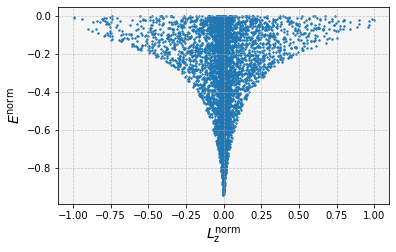

In [10]:
plt.figure()
plt.scatter(Lz_ini_norm, E_ini_norm, s = 2)
plt.ylabel(r'$E^\mathrm{norm}$', fontsize = 14, fontweight = 'bold')
plt.xlabel(r'$L_\mathrm{z}^\mathrm{norm}$', fontsize = 14, fontweight = 'bold') 
plt.gca().set_facecolor('whitesmoke')
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout(pad=2.5)
plt.show()

## Generate and integrate orbits

In [11]:
initial = [[R[i] * u.kpc, vR[i] * u.km/u.s, vT[i] * u.km/u.s, 0. * u.kpc, 0. * u.km/u.s, 0.* u.rad] for i in range(N)]
o_cdm = Orbit(initial) #orbit with Chandrasekhar DF
o_fdm = Orbit(initial) #orbit with FDM DF

In [12]:

t = np.linspace(t0, tf, Nsteps) * u.Gyr
o_cdm.integrate(t, NFWHalo+cdf, method = 'dop853_c')
o_fdm.integrate(t, NFWHalo+fdf, method = 'dop853_c')

## Analysis

### Compute the fall-in time $\tau_f$

In [13]:
def find_apocentre_crossing_times(t, r_array, rs, default_value=10):
    """
    Finds the first time when the apocentre goes below rs for each orbit.
    If there is no crossing, returns default_value (e.g. 10).

    Arguments:
        t : (Nt,) array of times
        r_array : (N_orbits, Nt) array of radii
        rs : radius threshold
        default_value : value to return if no apocentre goes below rs

    Returns:
        t_crossings : (N_orbits,) array of times or default_value
    """
    dr = np.diff(r_array, axis=1)
    rising = dr[:, :-1] > 0
    falling = dr[:, 1:] < 0
    is_apocentre = rising & falling

    apocentre_indices = np.where(is_apocentre)
    t_crossings = np.full(r_array.shape[0], default_value, dtype=float)

    for i_orb in range(r_array.shape[0]):
        indices = apocentre_indices[1][apocentre_indices[0] == i_orb]
        r_apo = r_array[i_orb, indices + 1]
        t_apo = t[indices + 1]
        below = np.where(r_apo < rs)[0]
        if below.size > 0:
            t_crossings[i_orb] = t_apo[below[0]]

    return t_crossings

In [14]:
tau_cdm = find_apocentre_crossing_times(t.value, o_cdm.R(t), 0.1 * r_s, default_value = tf)
tau_fdm = find_apocentre_crossing_times(t.value, o_fdm.R(t), 0.1 * r_s, default_value = tf)

### Normalization

In [15]:
#Dimensionless quantities
Lz_cdm =  o_cdm.Lz()/np.max(np.abs(o_cdm.Lz()))
E_cdm =  o_cdm.E()/abs(Emin) 
Lz_fdm =  o_fdm.Lz()/np.max(np.abs(o_fdm.Lz()))
E_fdm =  o_fdm.E()/abs(Emin) 

## Plots

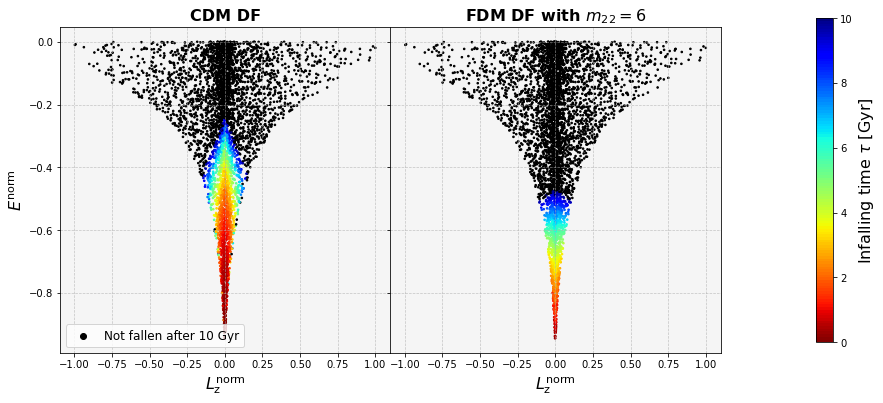

In [16]:
special_value = tf  
special_color = 'black'

# Créer une colormap personnalisée
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1, 121))
special_cmap = ListedColormap(colors)
special_cmap.set_under(special_color)

# Définir les limites et les normes
bounds = np.linspace(t0, tf, 121)
norm = BoundaryNorm(bounds, special_cmap.N)

fig, ax = plt.subplots(1, 2, figsize = (12, 6), gridspec_kw={'wspace': 0})

sc1 = ax[0].scatter(Lz_cdm, E_cdm, marker = '.',c = tau_cdm, cmap = special_cmap.reversed(), norm = norm, s = 10)
ax[0].scatter([], [], c=special_color, label=f'Not fallen after {t[-1]:.0f}')
ax[0].legend(fontsize = 12)
ax[0].set_ylabel(r'$E^\mathrm{norm}$', fontsize = 16, fontweight = 'bold')
ax[0].set_xlabel(r'$L_\mathrm{z}^\mathrm{norm}$', fontsize = 16, fontweight = 'bold') 
ax[0].set_facecolor('whitesmoke')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax[0].set_title('CDM DF', fontsize = 16, fontweight = 'bold')

sc2 = ax[1].scatter(Lz_fdm, E_fdm, marker = '.',c = tau_fdm, cmap = special_cmap.reversed(), norm = norm, s = 10)
ax[1].set_xlabel(r'$L_\mathrm{z}^\mathrm{norm}$', fontsize = 16, fontweight = 'bold') 
ax[1].scatter([], [], c=special_color, label=f'Not fallen after {t[-1]:.0f}')
ax[1].set_title('FDM DF with $m_{22}=%d$'%(m*1e22), fontsize = 16, fontweight = 'bold')
ax[1].set_facecolor('whitesmoke')
ax[1].grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax[1].set_yticklabels([])  # Enlève les labels des ticks de l'axe y

# Ajuster la figure pour laisser de la place à la colorbar à droite
fig.subplots_adjust(right=0.89)
import matplotlib as mpl
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.75])  # [left, bottom, width, height], bien à droite
cbar = fig.colorbar(sc2, cax=cbar_ax)
cbar.set_label(r'Infalling time $\tau$ [Gyr]', fontsize = 16)
cbar.set_ticks(np.linspace(t0, tf, 6))
plt.show()